In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import data_loader
from models.sankar import *
import utils

In [2]:
os.getcwd()

'/Users/nishant/Desktop/Spring 2021/NASA-Intern/Codes/nishant-trials'

In [12]:
# Hyperparameters
IMG_SIZE = 28
BATCH_SIZE = 1024
EPOCHS = 2
LR = 2e-3

N_CLASSES = 10
NUM_FILTERS_DISC = 64
NUM_FILTERS_GEN = 64
Z_DIM = 512
N_DIM = 2 * NUM_FILTERS_DISC

ADV_WEIGHT = 0.1
ALPHA = 0.3

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
# MNIST
transform_m = transforms.Compose(
    [transforms.Resize(32), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

trainset_m = datasets.MNIST(
    "./data/mnist", train=True, download=False, transform=transform_m
)
trainloader_m = torch.utils.data.DataLoader(
    trainset_m, batch_size=BATCH_SIZE, shuffle=True
)

testset_m = datasets.MNIST(
    "./data/mnist", train=False, download=False, transform=transform_m
)
testloader_m = torch.utils.data.DataLoader(
    testset_m, batch_size=BATCH_SIZE, shuffle=True
)

# MNIST-M
transform_mm = transforms.Compose(
    [transforms.Resize(32), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

DATA_DIR = "data/mnist_m/processed/"

trainloader_mm = data_loader.fetch(
    data_dir=os.path.join(DATA_DIR, "mnist_m_train.pt"),
    batch_size=BATCH_SIZE,
    shuffle=True,
    transform=transform_mm,
)

testloader_mm = data_loader.fetch(
    data_dir=os.path.join(DATA_DIR, "mnist_m_test.pt"),
    batch_size=BATCH_SIZE,
    shuffle=False,
    transform=transform_mm,
)

In [14]:
num_batches = min(len(trainloader_m), len(trainloader_mm)) # ~60000/batch_size
num_batches

59

In [15]:
net_G = Generator(N_DIM, Z_DIM, N_CLASSES, NUM_FILTERS_GEN).to(device)
net_D = Discriminator(N_CLASSES, NUM_FILTERS_DISC).to(device)
net_F = FeatureExtractor(NUM_FILTERS_DISC).to(device)
net_C = ClassifierNet(NUM_FILTERS_DISC, N_CLASSES).to(device)

In [16]:
net_G.apply(utils.weights_init)
net_D.apply(utils.weights_init)
net_F.apply(utils.weights_init)
net_C.apply(utils.weights_init)

ClassifierNet(
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [17]:
optimizer_D = optim.Adam(net_D.parameters(), lr=LR)
optimizer_G = optim.Adam(net_G.parameters(), lr=LR)
optimizer_F = optim.Adam(net_F.parameters(), lr=LR)
optimizer_C = optim.Adam(net_C.parameters(), lr=LR)

In [18]:
criterion_classifier = nn.CrossEntropyLoss()
criterion_domain = nn.BCELoss()

In [19]:
real_labels = torch.ones(BATCH_SIZE).to(device)
fake_labels = torch.zeros(BATCH_SIZE).to(device)

print(real_labels.shape)
print(fake_labels.shape)

torch.Size([1024])
torch.Size([1024])


In [20]:
torch.autograd.set_detect_anomaly(True)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch+1}")

    net_D.train()
    net_G.train()
    net_F.train()
    net_C.train()

    for i, (data_source, data_target) in enumerate(zip(trainloader_m, trainloader_mm)):
        print(f"batch: {i+1}")

        src_inputs, src_labels = data_source
        tgt_inputs, _ = data_target

        src_inputs = src_inputs.expand(src_inputs.shape[0], 3, 32, 32)

        src_inputs, src_labels = src_inputs.to(device), src_labels.to(device)
        tgt_inputs = tgt_inputs.to(device)

        # Creating one-hot vectors
        src_labels_onehot = torch.zeros(BATCH_SIZE, N_CLASSES + 1).to(device)
        tgt_labels_onehot = torch.zeros(BATCH_SIZE, N_CLASSES + 1).to(device)

        for num in range(BATCH_SIZE):
            src_labels_onehot[num, int(src_labels[num])] = 1
            tgt_labels_onehot[num, N_CLASSES] = 1

        # Updating Discriminator net_D
        net_D.zero_grad()
        src_embeddings = net_F(src_inputs)  # [-1, 128]
        src_noise = noise = torch.randn(BATCH_SIZE, Z_DIM)
        src_concat = torch.cat((src_embeddings, src_labels_onehot, src_noise), 1)
        src_gen = net_G(src_concat.detach())

        tgt_embeddings = net_F(tgt_inputs)
        tgt_noise = noise = torch.randn(BATCH_SIZE, Z_DIM)
        tgt_concat = torch.cat((tgt_embeddings, src_labels_onehot, src_noise), 1)
        tgt_gen = net_G(tgt_concat.detach())

        src_D_domain_real, src_D_classes_real = net_D(src_inputs)

        loss_src_D_domain_real = criterion_domain(src_D_domain_real, real_labels)
        loss_src_D_classes_real = criterion_classifier(src_D_classes_real, src_labels)

        src_D_domain_gen_fake, src_D_classes_gen_fake = net_D(src_gen.detach())
        loss_src_D_domain_gen_fake = criterion_domain(
            src_D_domain_gen_fake, fake_labels
        )

        tgt_D_domain_gen_fake, _ = net_D(tgt_gen.detach())
        loss_tgt_D_domain_gen_fake = criterion_domain(
            tgt_D_domain_gen_fake, fake_labels
        )

        loss_D = (
            loss_src_D_domain_real
            + loss_src_D_classes_real
            + loss_src_D_domain_gen_fake
            + loss_tgt_D_domain_gen_fake
        )

        loss_D.backward(retain_graph=True)
        optimizer_D.step()

        # Recompute net_D after gradient update
        src_D_domain_gen_fake, src_D_classes_gen_fake = net_D(src_gen)
        tgt_D_domain_gen_fake, _ = net_D(tgt_gen)

        # Updating Generator net_G
        net_G.zero_grad()

        loss_G_domain = criterion_domain(src_D_domain_gen_fake, real_labels)
        loss_G_classes = criterion_classifier(src_D_classes_gen_fake, src_labels)
        loss_G = loss_G_domain + loss_G_classes

        loss_G.backward(retain_graph=True)
        #optimizer_G.step()

        # Update Classifier net C
        net_C.zero_grad()

        output_C = net_C(src_embeddings)
        loss_C = criterion_classifier(output_C, src_labels)

        loss_C.backward(retain_graph=True)
        #optimizer_C.step()

        # Update Feature Extractor F
        net_F.zero_grad()

        loss_F_src = ADV_WEIGHT * criterion_classifier(
            src_D_classes_gen_fake, src_labels
        )
        loss_F_tgt = (
            ADV_WEIGHT * ALPHA * criterion_domain(tgt_D_domain_gen_fake, real_labels)
        )

        loss_F = loss_C + loss_F_src + loss_F_tgt
        
#         print(loss_F)

        loss_F.backward()

        optimizer_G.step()
        optimizer_C.step()
        optimizer_F.step()
        
        running_loss_total += loss_C

        if i % 300 == 0:
          print(f"Epoch: {epoch}/{EPOCHS} Batch: {i}/{num_batches}")
          print(f"Classifier Training Loss: {running_loss_total/batch}")
          


    net.eval()
    test_loss = 0 
    accuracy = 0

    with torch.no_grad():
            net.eval()
            for imgs, lbls in testloader_mm:
                imgs, lbls = imgs.to(device), lbls.to(device)
                #print(logits.shape,lbls.shape)
                logits, _ = net_C(imgs, lamda)
                #print(logits.shape)
                #print(lbls.shape)
                #lbls = lbls.view(*logits.shape)
                #print(logits.shape,lbls.shape)
                test_loss += criterion_l(logits, lbls)

                #logits to probabilities using softmax
                ps = torch.exp(logits) / (torch.sum(torch.exp(logits)))
                top_p, top_class = ps.topk(1, dim=1)
                #print(top_p.shape, top_class.shape)
                equals = top_class == lbls.view(*top_class.shape)
                #print(top_class,lbls.view(*top_class.shape))
                accuracy += torch.mean(equals.float())

    test_accuracy.append(accuracy / len(testloader_mm))
    print(f"Test accuracy: {accuracy / len(testloader_mm)}")
    print("\n")

        
        
        

epoch: 1
batch: 1


KeyboardInterrupt: 

In [49]:
# from torchviz import *

# make_dot(y.mean(), params=dict(model.named_parameters()))

In [53]:
# from scipy.io import loadmat
# x = loadmat('data/USPS_all.mat')
# x.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data'])

In [57]:
# x['data'].shape

(256, 1100, 10)

In [99]:
# y = x['data'][:,141,1].reshape(16,16)
# y = y.T


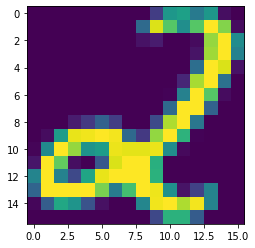

In [100]:
# import matplotlib.pyplot as plt

# plt.imshow(y)